In [6]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
os.chdir("../models")
from model import CustomCNN
# from common_utils import set_seed, EarlyStopper, train, get_mean_rgb, CustomTransform
from common_utils import set_seed, EarlyStopper, train, get_mean_rgb, CustomTransform
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2
from PIL import Image
import numpy as np

# set seed
set_seed(42)

In [2]:
model = CustomCNN() # initialise model

mean_rgb = get_mean_rgb(datasets.Flowers102(root='../data', split='test', download=True, transform=transforms.ToTensor())) # get mean rgb values of dataset
transform = CustomTransform(mean_rgb) # initialise transform

# load data
train_dataset = datasets.Flowers102(root='../data', split='test', download=True, transform=transform) 
val_dataset = datasets.Flowers102(root='../data', split='val', download=True, transform=transform) 
test_dataset = datasets.Flowers102(root='../data', split='train', download=True, transform=transform)
# NOTE: Due to a bug with the Flowers102 dataset, the train and test splits are swapped

# batch_size = 8
batch_size = 128
# initialise dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Generate a kernel where the center is focused
def center_focused_kernel(v):
    x, y = torch.meshgrid(torch.linspace(-1, 1, v), torch.linspace(-1, 1, v))
    distance = torch.exp(np.sqrt(x**2 + y**2))
    kernel = torch.exp(-0.5 * distance)
    kernel /= kernel.max()

    return kernel

# Find a square bounding box of combined_map
def find_bounding_box(combined_map):
    w, h = combined_map.shape
    v = min(w, h)
    combined_map_torch = torch.tensor(combined_map).view(1, 1, w, h)

    max_value = -1 * np.inf
    y_0, y_1, x_0, x_1 = None, None, None, None
    
    # start from smallest of width and height and decrease by -25 until 200 pixels
    for v in range(min(w,h), 100-1, -25):
        kernel = center_focused_kernel(v)
        kernel = kernel.view(1, 1, v, v) / ( v * v )
        
        res = F.conv2d(combined_map_torch, kernel, stride = 25)
        
        _, _, t1, t2 = res.shape
        res = res.reshape(t1, t2)

        curr_max = torch.max(res)

        # Penalise small bounding boxes
        curr_value = curr_max * (v / w)
        
        if curr_value > max_value:
            max_value = curr_value
            t = (res == curr_max).nonzero()

            y_0 = t[0, 0].item()
            y_1 = y_0 + v
            
            x_0 = t[0, 1].item()
            x_1 = x_0 + v

        
    return y_0, y_1, x_0, x_1

C:\Users\min\AppData\Local\Temp\ipykernel_12004\1929198539.py:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  cropped_resized_img = Image.fromarray(cropped_img).resize((100, 100), Image.ANTIALIAS)


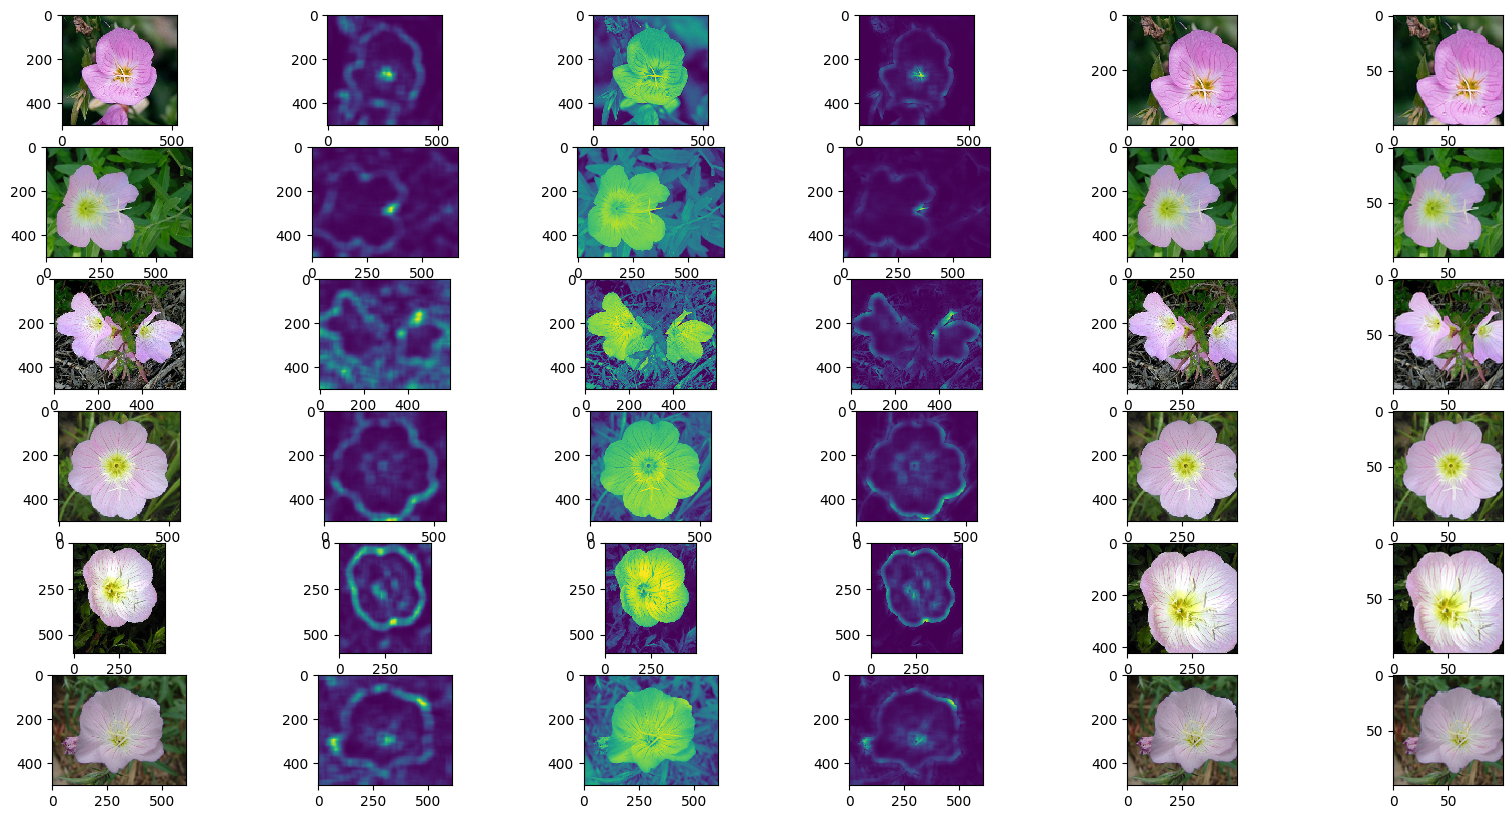

In [11]:
train_dataset_ = datasets.Flowers102(root='../data', split='test', download=True, transform=transforms.ToTensor())
fig, axs = plt.subplots(6, 6, figsize=(20,10))

for i in range(6):
    # get saliency map
    image = train_dataset_[i][0].permute(1,2,0).numpy()
    saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
    # saliency = cv2.saliency.StaticSaliencyFineGrained_create()
    success, saliency_map = saliency.computeSaliency(image)
    
    # get luminance map
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    luminance_map = l_channel / 256
    
    combined_map = saliency_map * luminance_map
    
    # Find the most salient square patch coordinates (x, y, w, h)
    # min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(combined_map)
    # w, h = int(image.shape[1] * 0.8), int(image.shape[0] * 0.8)  # 80% of the original dimensions
    # x = max(max_loc[0] - w // 2, 0)
    # y = max(max_loc[1] - h // 2, 0)

    y_0, y_1, x_0, x_1 = find_bounding_box(combined_map)
    
    cropped_img = (image[y_0:y_1, x_0:x_1]*255).astype("uint8")
    
    # Crop and resize the image to 100x100
    cropped_resized_img = Image.fromarray(cropped_img).resize((100, 100), Image.ANTIALIAS)


    axs[i, 0].imshow(image, interpolation="nearest")
    axs[i, 1].imshow(saliency_map, interpolation="nearest")
    axs[i, 2].imshow(luminance_map, interpolation="nearest")
    axs[i, 3].imshow(combined_map, interpolation="nearest")
    axs[i, 4].imshow(cropped_img, interpolation="nearest")
    axs[i, 5].imshow(cropped_resized_img, interpolation="nearest")